In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm

import numpy as np
import os

import matplotlib.pyplot as plt

bands = [4,5,6,7,8,9]

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

2022-03-08 10:32:25.258979: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-03-08 10:32:25.259025: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 21
max_number = 4
batch_size = 1
max_shift = None
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=17

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="real",
    seed=seed,
)

In [3]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    x_crop_start = int(round(pos[0] - (cutout_pixel_size-1)/2))
    x_crop_end = int(round(pos[0] + (cutout_pixel_size-1)/2))
    
    y_crop_start = int(round(pos[1] - (cutout_pixel_size-1)/2))
    y_crop_end = int(round(pos[1] + (cutout_pixel_size-1)/2))
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [47]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

(6, 105, 105)

input_image


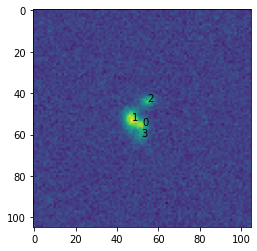

In [48]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


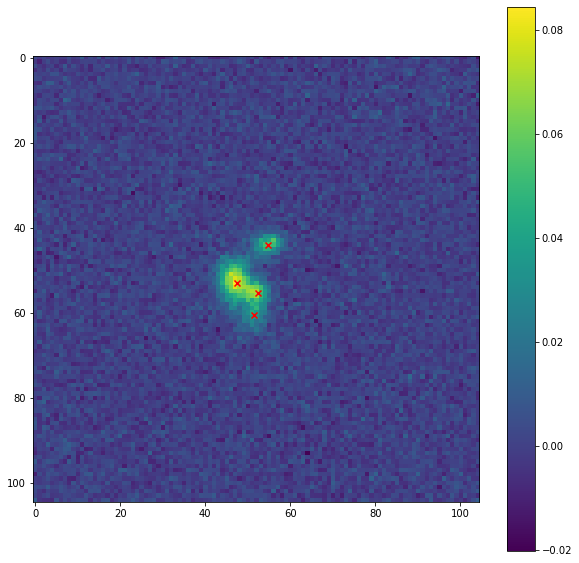

In [49]:
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2]/80000)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
fig.colorbar(im1, ax=ax)

In [50]:
detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

print(detected_positions)
deb = Deblend(blend['blend_images'][0]/80000, detected_positions, num_components=len(blend['blend_list'][0]), use_likelihood=True)


[[55.219065112569666, 52.306759037484305], [52.88704581900887, 47.360952404564536], [44.0454340410562, 54.728282133515435], [60.583498542241806, 51.56300729713713]]
in cropping
(105, 105, 6)
105
using encoder for initial point


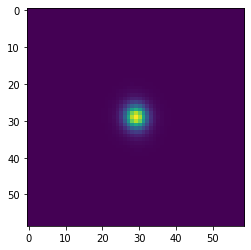

In [51]:
plt.imshow(deb.components[0][:, :, 2])

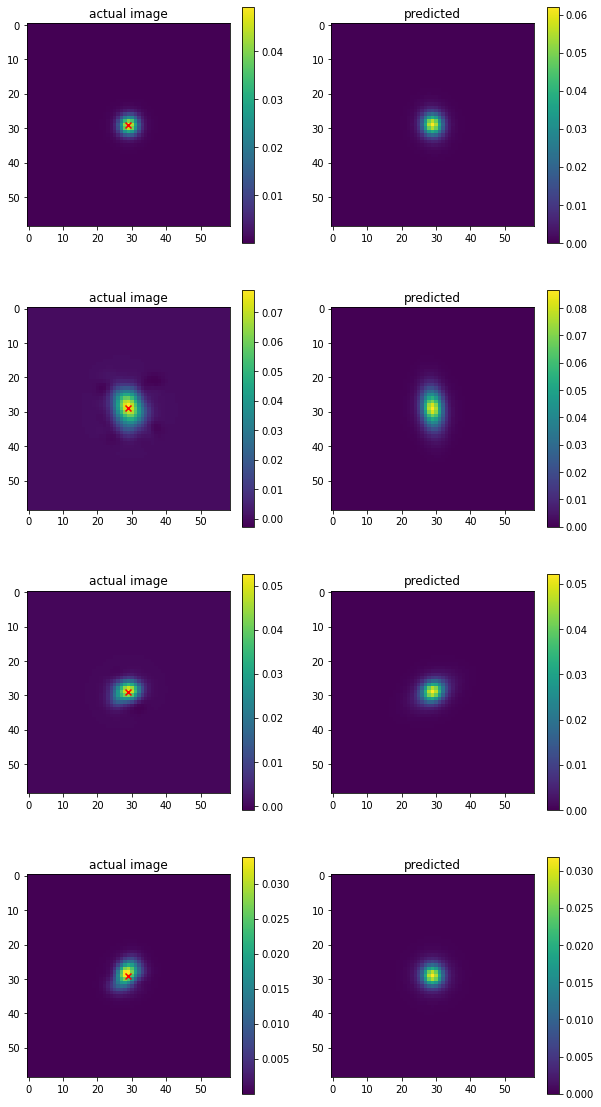

In [52]:
 fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 11.8))
    fig.colorbar(im1, ax=ax[i, 0])
    ax[i, 0].set_title("actual image")
    ax[i, 0].scatter(29, 29, c="r", marker="x")

    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    fig.colorbar(im2, ax=ax[i, 1])
    ax[i, 1].set_title("predicted")
    
plt.show()

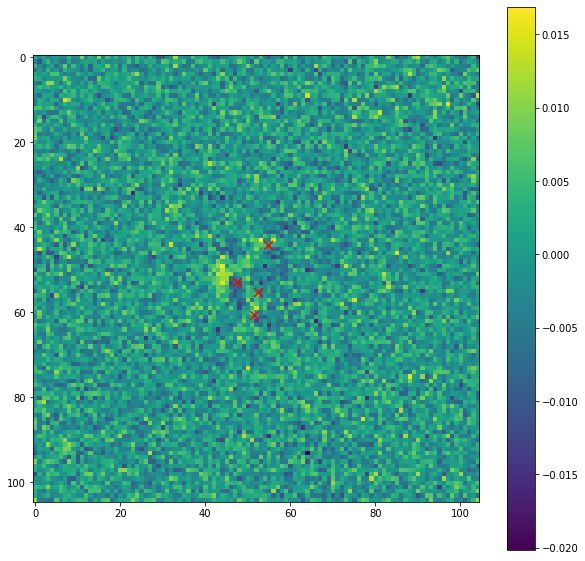

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
residual = deb.compute_residual()
im1 = ax.imshow(residual[:, :, 2])
fig.colorbar(im1, ax=ax)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", s=80, c="r")

# Now compare to debvader output

In [54]:
from debvader.model import load_deblender
from debvader.deblender import deblend, DeblendField
from debvader.detection import detect_objects
from debvader.extraction import extract_cutouts
from debvader.normalize import LinearNormCosmos

In [55]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [56]:
# Load the network using the load_deblender function
net, encoder, decoder, z = load_deblender(loading_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/2step_scheduled_lr/deblender/val_loss', 
                                          input_shape=input_shape,
                                          latent_dim=latent_dim, 
                                          filters=filters, 
                                          kernels=kernels, 
                                          return_encoder_decoder_z=True)

in cropping
weights loaded from: /pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/2step_scheduled_lr/deblender/val_loss


In [57]:
blended_image = np.transpose(blend['blend_images'][0], axes = (1,2,0)).copy()
detected_positions_to_center = list(np.array(detected_positions) - (stamp_size*5-1)/2)
Deblender = DeblendField(net, blended_image, normalizer=LinearNormCosmos())
res_deblending_btk = Deblender.deblend_field(detected_positions_to_center)

[array([3.21906511, 0.30675904]), array([ 0.88704582, -4.6390476 ]), array([-7.95456596,  2.72828213]), array([ 8.58349854, -0.4369927 ])]


In [58]:
res_deblending_btk_meta = Deblender.get_deblending_meta_data()

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

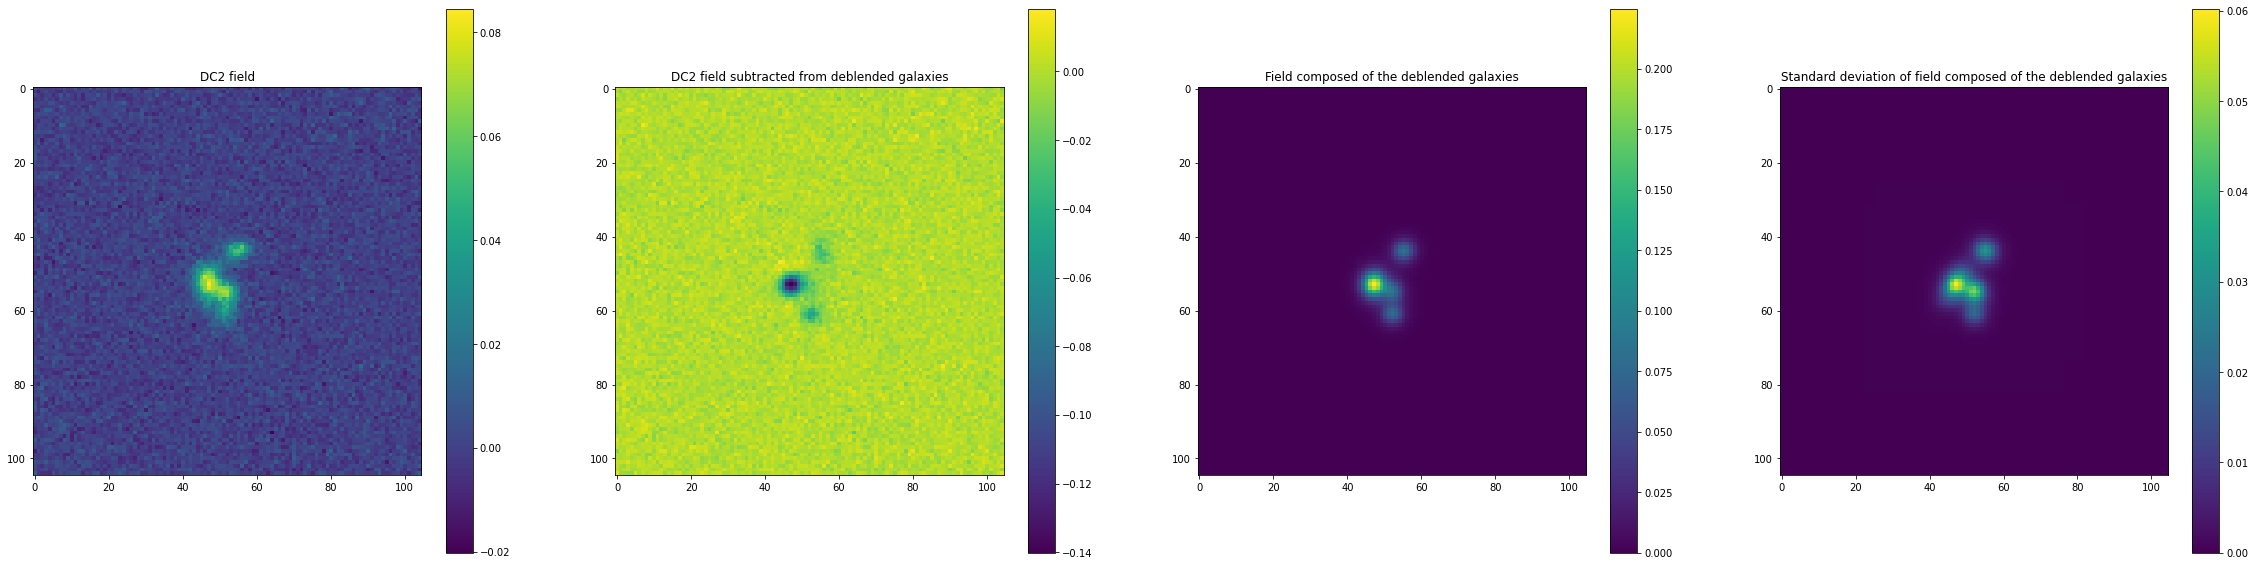

In [59]:
bands = 2

fig, axes = plt.subplots(1,4, figsize = (40,10))
im = axes[0].imshow(res_deblending_btk_meta['field_image'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[0])
im = axes[1].imshow(res_deblending_btk_meta['deblended_image'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[1])
im = axes[2].imshow(res_deblending_btk_meta['predicted_mean_field'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[2])
im = axes[3].imshow(res_deblending_btk_meta['predicted_stddev_field'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[3])

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')